In [1]:
import torch
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv

In [2]:
import numpy as np

#### Technical functions

In [3]:
import h5py
import numpy as np
import pandas as pd

In [4]:
def load_nodesnedges_h5py(h5file, hash_mol):
    """
    Load data from one molecule (group) from a h5py
    file (h5file) using the specific hash (hash_mol).
    """
    # Load a specific molecule using the hash
    id_mol = f"sample_{hash_mol}"
    with h5py.File(h5file, 'r') as f:
        # Load global parameters
        global_params = dict(f.attrs)
        print("Global params:", global_params)

        # Access a specific sample using the hash
        sample = f[id_mol]
        # load arrays
        return [
            sample.attrs["name"],
            sample["Node_features"][:],
            sample["Edge_list"][:],
            sample["Edge_features"][:]
        ]

In [5]:
def loadseveral_nodesnedges_h5py(h5file):
    """
    Load data from several molecules (groups) from a h5py
    file (h5file).
    Do not use this function for hundreds/thousands of 
    molecules.
    """
    data = {}
    with h5py.File(h5file, 'r') as mol:
        for group_name in mol.keys(): # iteration through groups (molecules)
            group = mol[group_name]
            data[group_name] = {
                "features" : {
                    "Node_features": group["Node_features"][:], # Shape (#atoms, 14)
                    "Edge_list": group["Edge_list"][:], # Shape (2, atoms*(atoms-1))
                    "Edge_features": group["Edge_features"][:], # Shape (atoms*(atoms-1), 8)
                },
                "metadata": dict(group.attrs), # Name, hash
            }
    return data

In [6]:
def load_conditions(conditions_file):
    """
    Load conditions, those are pre-defined by the user
    in an external file and return a dictionary having this
    information.
    """
    parameters= {}
    with open(conditions_file, 'r', encoding="utf-8") as params:
        for param in params:
            param = param.strip()
            parameters[param.split(':')[0].strip()] = eval(param.split(':')[1].strip())
    return parameters

In [7]:
def save_embeddings(mol_embeddings, list_dicts, gat_params, data_set_name="data_embeddings_etdac.h5"):
    """
    Saves the GAT embeddings obtained using GatConv2 model witht the ETDAC matrix calculation
    Args:
    mol_embeddings (np.array): array of real values that represent the 
     embeddings from the GAT convolution.
    list_dicts (list): each element of the list is a dictionary having
     keys: 'hash' and 'name' and its corresponding values.
    The order of mol_embeddings and list_dicts should be the SAME cause
     is that default sorted used to save information in the .h5 file.
    gat_params (dict): global parameters considered important for the
     data file generated.
    data_set_name (str): the name of the new file, by default is
     "data_embeddings_etdac.h5"
    """
    
    with h5py.File(data_set_name, 'w') as f:
        # Save the global parameters as attributes once for the file
        for key, value in gat_params.items():
            f.attrs[key] = value

        # Assuming both are in the same order
        for embeddings, dict in zip(mol_embeddings, list_dicts):

            # Create a group for the sample molecule
            mol_group = f.create_group(f"sample_{dict['hash']}")
            
            # Save arrays (with compression to reduce file size)
            mol_group.create_dataset("mol_embeddings", data=embeddings, compression="gzip")
            
            # Save individual attributes
            mol_group.attrs["name"] = dict['name']
            mol_group.attrs["hash"] = dict['hash']    

###### Load data

In [8]:
#### Load H5PY file
h5file = 'data_etdac_metadata.h5'

In [9]:
# Load information from H5PY in a dictionary
raw_full_data = loadseveral_nodesnedges_h5py(h5file)
#raw_full_data['sample_f43']

In [10]:
# Load and save all molecule node features in a single list
test_nodesfeat = [raw_data['features']['Node_features'] for raw_data in raw_full_data.values()]

In [11]:
# Load and save all molecule edge list in a single list
# to correct in the previous code: all info is repeated, loading only one of them is enough
#test50_edgelist = [raw_data['features']['Edge_list'] for raw_data in raw_full_data.values()]
edgelist = raw_full_data['sample_f00']['features']['Edge_list']

In [12]:
# Load and save all molecule feature edge in a single list
test_edgefeat = [raw_data['features']['Edge_features'] for raw_data in raw_full_data.values()]

##### Modification on data
###### Prepare input data

In [13]:
# Highlight flagged nodes (cross-feature flag) multupliting by 10
#node_feats_test = [np.c_[nodefeat[:, :-1], nodefeat[:, -1:] * 1] for nodefeat in test_nodesfeat]
node_feats = [nodefeat for nodefeat in test_nodesfeat]

In [14]:
# Highlight flagged edges (cross-feature flag) multupliting by 20 the second last column and by 15 the last one
#edge_feats_test = [np.c_[edge[:, :-2], edge[:, -2:-1] * 10, edge[:, -1:] * 2] for edge in test_edgefeat]
edge_feats = [edgefeat for edgefeat in test_edgefeat]

In [15]:
# Use Pytorch to transform data into tensors
from torch_geometric.data import Data

In [16]:
# Diagnosis of the node features
#total of data points in node_feats
total = node_feats[0].shape[0] * node_feats[0].shape[1] * len(node_feats)
print(f"Total number of points: {total}, 100%")
#one-value points in node_feats
val_tmp = np.sum(np.array([np.where(node_feat == 1)[0].shape[0] for node_feat in node_feats]))
print(f"Number of one-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")
#zero-value points in node_feats
val_tmp = np.sum(np.array([np.where(node_feat == 0)[0].shape[0] for node_feat in node_feats]))
print(f"Number of zero-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")

Total number of points: 40500, 100%
Number of one-value points: 15300, 37.78%
Number of zero-value points: 25200, 62.22%


In [17]:
# Diagnosis of the edge features
#total of data points in edge_feats
total = edge_feats[0].shape[0] * edge_feats[0].shape[1] * len(edge_feats)
print(f"Total number of points: {total}, 100%")
#one-value points in edge_feats
val_tmp = np.sum(np.array([np.where(edge_feat == 1)[0].shape[0] for edge_feat in edge_feats]))
print(f"Number of one-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")
#zero-value points in edge_feats
val_tmp = np.sum(np.array([np.where(edge_feat == 0)[0].shape[0] for edge_feat in edge_feats]))
print(f"Number of zero-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")
#three-value points in edge_feats
val_tmp = np.sum(np.array([np.where(edge_feat[:, -2:-1] == 1)[0].shape[0] for edge_feat in edge_feats]))
print(f"Number of cross-feature flag points part 1: {val_tmp}, {(100*val_tmp)/total:.5f}%")
#ten-value points in edge_feats
val_tmp = np.sum(np.array([np.where(edge_feat[:, -1:] == 1)[0].shape[0] for edge_feat in edge_feats]))
print(f"Number of cross-feature flag points part 2: {val_tmp}, {(100*val_tmp)/total:.5f}%")
#non-integer-value points in edge_feats
val_tmp = np.sum(np.array([np.where(
    (edge_feat != 1) & (edge_feat != 0) & (edge_feat != 10) & (edge_feat != 2)
)[0].shape[0] for edge_feat in edge_feats]))
print(f"Number of real-value points: {val_tmp}, {(100*val_tmp)/total:.2f}%")

Total number of points: 486000, 100%
Number of one-value points: 13668, 2.81%
Number of zero-value points: 338914, 69.74%
Number of cross-feature flag points part 1: 496, 0.10206%
Number of cross-feature flag points part 2: 572, 0.11770%
Number of real-value points: 133418, 27.45%


#### GAT model

In [18]:
def set_seed(seed):
    """
    Receive an integer to set the seed for randomness before
    GAT procedure
    """
    torch.manual_seed(seed)  
    np.random.seed(seed)  
    if torch.cuda.is_available():  
        torch.cuda.manual_seed_all(seed)
    # Minor numerical differences in softmax accumulate across batches
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [19]:
# Create PyG Data object for more "molecules"
number_of_mol = len(node_feats) # total of group data
g = torch.Generator()
g.manual_seed(42)
pyg_data_list = [
    Data(
        x=torch.tensor(node_feats[i], dtype=torch.float32),
        edge_index=torch.tensor(edgelist, dtype=torch.long),
        edge_attr=torch.tensor(edge_feats[i], dtype=torch.float32),
        generator=g # to preserve reproducibility
    )
    for i in range(number_of_mol)  # For 100 molecules
]

In [20]:
print("Number of edges:", pyg_data_list[0].edge_index.shape[1])  # Should be 810
print("Edge features shape:", pyg_data_list[0].edge_attr.shape)  # Must be [810, 6]
assert pyg_data_list[0].edge_index.shape[1] == pyg_data_list[0].edge_attr.shape[0]

Number of edges: 810
Edge features shape: torch.Size([810, 6])


In [21]:
from torch_geometric.nn import LayerNorm  # PyG's built-in (for graph data)
import torch.nn as nn

In [22]:
class MyGAT(torch.nn.Module):  
    def __init__(self):  
        super().__init__()
        #self.norm = LayerNorm(in_channels=9)  # Match node feature dim
        self.conv = GATv2Conv(
            in_channels=9,         # Matches node feature dim (9)
            out_channels=32,        # Embedding dimension
            heads=1,                # 1 to capture rare features from multiple subspaces
            edge_dim=6,             # Matches edge_attr dim (6)
            concat=False,            # Combines multi-head outputs (preserves all dimensions; required for sparse feature retention)
            add_self_loops=False,    # Disable if edges are already undirected. Edges are directed but the
             # architecture of the edge_list and adge values are fully connected (undirected)
            bias=False,  # Disable to prevent drowning sparse signals
            #negative_slope=0.5  # Less aggressive than default LeakyReLU (avoids over-squashing near-zero edges)
            negative_slope=0.03,    # to make attention more sensitive to small values.
            flow='target_to_source',  # Better handles directed edges
            dropout=0.0,             # (temporarily) to prevent masking rare flags
            share_weights=True  # Helps with directed edges
        )  # GATv2Conv for dynamic attention, less prone to softmax suppression
        
        # Learnable edge feature scalers
        # Initial scaling factors
        #self.edge_scalers = torch.nn.Parameter(torch.tensor([1.0, 1.0, 1.0, 1.0, 6.0, 2.5]))
        # Additive boost
        self.flag_boost = torch.nn.Parameter(torch.tensor([0.0, 0.0, 0.0, 0.0, 3.0, 1.5]))

    def forward(self, x, edge_index, edge_attr):

        # Scale + boosted_flags
        scaled_edge_attr = edge_attr + (
            edge_attr * self.flag_boost.abs()) 
        x, (edge_index, att_weights) = self.conv(
            x, edge_index, scaled_edge_attr, 
            return_attention_weights=True
        )
        # Save weights for later inspection
        self.att_weights = att_weights
    
        return x

In [23]:
#GAT Layer (two-head)
#conv = GATConv(
#conv = GATv2Conv(           # dynamic attention, less prone to softmax suppression
#    in_channels=14,         # Matches node feature dim (14)
#    out_channels=64,        # Embedding dimension
#    heads=2,                # 1 to capture rare features from multiple subspaces
#    edge_dim=8,             # Matches edge_attr dim (8)
#    concat=True,            # Combines multi-head outputs (preserves all dimensions; required for sparse feature retention)
#    add_self_loops=False,    # Disable if edges are already undirected
#    bias=False,  # Disable to prevent drowning sparse signals
#    #negative_slope=0.5  # Less aggressive than default LeakyReLU (avoids over-squashing near-zero edges)
#    negative_slope=0.01,    # to make attention more sensitive to small values.
#    dropout=0.0             # (temporarily) to prevent masking rare flags
#)

In [24]:
# to load and pool data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool

In [25]:
set_seed(42)  # Call this before training
mol_embeddings = []  # Will store all molecule embeddings
# Data set is pyg_data_list
loader = DataLoader(pyg_data_list, batch_size=10)#, shuffle=False)

mygat_conv = MyGAT()  # Instantiate customized GAT

# Warm-up pass (only once) / lazy layers problem
dummy_x = torch.randn(5, pyg_data_list[0].x.shape[1], dtype=torch.float32)
dummy_edge_index = torch.randint(0, 5, np.array(pyg_data_list[0].edge_index).shape, dtype=torch.long)
dummy_edge_attr = torch.randint(0, 5, np.array(pyg_data_list[0].edge_attr).shape, dtype=torch.float32)
with torch.no_grad():
    mygat_conv(dummy_x, dummy_edge_index, dummy_edge_attr)

#pyg_data_list[0].x.shape, pyg_data_list[0].edge_index.shape
for batch in loader:
    # batch.x: [num_nodes_in_batch, 14]
    #print(batch.x.shape)
    # batch.edge_index: [50, num_edges_in_batch]
    #print(batch.edge_index.shape)
    # batch.batch: Maps nodes to their molecule ID 
    #print(batch.batch.shape)

    # Get number of nodes per graph (batch-wise count)
    #_, counts = torch.unique(batch.batch, return_counts=True)
    #counts = counts.float().to(batch.x.device)  # Ensure same device/dtype as x
    
    # Node embeddings: [total_nodes_in_batch, 64]
    #node_embeddings = conv(batch.x, batch.edge_index, batch.edge_attr)
    node_embeddings = mygat_conv(batch.x, batch.edge_index, batch.edge_attr) # Forward pass (same as standalone conv)  
    print(node_embeddings.shape)
    # Pool to graph-level: [batch_size, 64]
    #mol_embed = global_mean_pool(node_embeddings, batch.batch)  # [50, 64]
    #mol_embed = global_add_pool(node_embeddings, batch.batch) #Preserving total signal strength
    #mol_embed = mol_embed / counts.unsqueeze(-1) #node counts don’t dilute scaled features
    # Hybrid pooling strategy
    mol_embed = (0.6 * global_add_pool(node_embeddings, batch.batch)) #Preserving total signal strength
    mol_embed = mol_embed + (0.4 * global_max_pool(node_embeddings, batch.batch)) #Highlight max
    print(mol_embed.shape)
    mol_embeddings.append(mol_embed)

    # checking model
    #print(torch.isnan(node_embeddings).any())  # Should be False
    #for idx, emb in enumerate(mol_embed):
    #    if torch.isnan(emb).any():
    #print(f"Node Embedding std: {torch.std(node_embeddings, dim=0)}")
    #print(f"Mol Embedding std: {torch.std(mol_embed, dim=0)}")
    #print(f"Embedding std: {torch.std(torch.stack(mol_embeddings), dim=0)}")
    active_dims = (torch.std(mol_embed, dim=0) > 0.1).sum().item()  
    print(f"Active dimensions: {active_dims}/32")
    
    # Step 1: Ensure edge_attr is compared per-edge (not per-feature)
    scaled_mask = (batch.edge_attr[:, 0] > 0.0)  # Assuming scaled value is in 6th column
    #print(f"Edge attribute: {batch.edge_attr[:, 6]}")
    # OR if all edge_attr features are scaled uniformly:
    # scaled_mask = (batch.edge_attr == 500.0).any(dim=1)  # Checks any feature == 500.0
    # Step 2: Select attention weights (shape: [num_edges, num_heads=2])
    mean_attention = mygat_conv.att_weights[scaled_mask, :].mean().item()
    print(f"Mean attention (×1 edges): {mean_attention:.4f}")

    # Step 3:  Feature Variance per Channel
    # Ideal: A few channels should have std ≈ 50+ (others near 0).
    #print("Per-channel std:", torch.std(node_embeddings, dim=0))  # Check which of 64 dims are active
    #active_dims = (torch.std(node_embeddings, dim=0) > 0.1).sum().item()  
   # print(f"Active dimensions: {active_dims}/64")
   # print(f"Embedding std: {torch.std(torch.stack(mol_embeddings), dim=0)}")

torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 1/32
Mean attention (×1 edges): 0.0220
torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 1/32
Mean attention (×1 edges): 0.0222
torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 1/32
Mean attention (×1 edges): 0.0220
torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 0/32
Mean attention (×1 edges): 0.0220
torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 0/32
Mean attention (×1 edges): 0.0222
torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 1/32
Mean attention (×1 edges): 0.0221
torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 0/32
Mean attention (×1 edges): 0.0221
torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 1/32
Mean attention (×1 edges): 0.0220
torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 0/32
Mean attention (×1 edges): 0.0221
torch.Size([450, 32])
torch.Size([10, 32])
Active dimensions: 1/32
Mean attention (×1 edges

In [26]:
# Concatenate all batches -> [num_molecules, 64]
mol_embeddings = torch.cat(mol_embeddings, dim=0)

In [27]:
mol_embeddings.shape

torch.Size([100, 32])

In [28]:
# If mol_embeddings is a torch.Tensor (shape [2, 64])
mol_embeddings_np = mol_embeddings.detach().cpu().numpy()  # Shape: [N, 64]

In [29]:
mol_embeddings_np.shape

(100, 32)

##### GAT diagnosis

In [30]:
# Diagnosis of the GAT embeddings
print("max and min: ", mol_embeddings_np.max(), mol_embeddings_np.min())
print("std and mean: ", mol_embeddings_np.std(), mol_embeddings_np.mean())
print("data points inside range -2 < x < 2: ",
      (100 * np.where((mol_embeddings_np > -2) & (mol_embeddings_np < 2))[0].shape[0])
      / (mol_embeddings_np.shape[0] * mol_embeddings_np.shape[1]),"%")
print("data points inside range x < -3.5 or x > 4.5: ", 
      (100 * np.where((mol_embeddings_np < -3.5) | (mol_embeddings_np > 4.5))[0].shape[0])
      / (mol_embeddings_np.shape[0] * mol_embeddings_np.shape[1]),"%")
print("total data points: ",
      mol_embeddings_np.shape[0] * mol_embeddings_np.shape[1])

max and min:  7.2617755 -5.4192944
std and mean:  3.3730993 -0.12731615
data points inside range -2 < x < 2:  40.625 %
data points inside range x < -3.5 or x > 4.5:  28.125 %
total data points:  3200


In [31]:
print("Embedding variances:", np.var(mol_embeddings_np, axis=0))

Embedding variances: [0.00131843 0.00019605 0.01046376 0.00267775 0.00026364 0.00104743
 0.0021774  0.00136159 0.00101083 0.00065739 0.00059761 0.00020579
 0.00040117 0.00045346 0.00049031 0.00277952 0.00263236 0.00107651
 0.00013048 0.0001482  0.00019085 0.00087462 0.00327138 0.00036125
 0.0006315  0.00158858 0.00047553 0.00053097 0.00119352 0.0019112
 0.00347729 0.00079379]


##### Saving GAT embeddings data

In [32]:
gat_params = load_conditions('gat_params_etdac.txt')
list_dicts = [raw_full_data[key]['metadata'] for key in raw_full_data.keys()]
save_embeddings(mol_embeddings_np, list_dicts, gat_params, data_set_name="data_embeddings_etdac.h5")

#### Dimensional reductionn test using PCA, t-SNE and UMAP and visualization

In [33]:
import matplotlib.pyplot as plt

In [34]:
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.decomposition import PCA

In [35]:
from sklearn.preprocessing import normalize

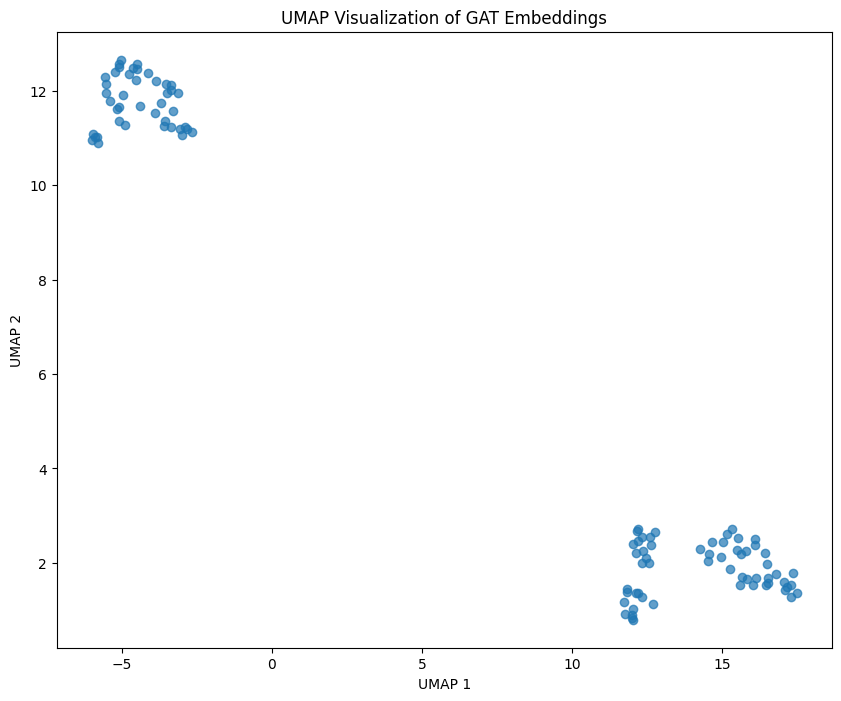

In [36]:
# UMAP visualization (usually better preserves global structure)
umap_model = umap.UMAP(
    n_components=2,          # For visualization
    n_neighbors=20,          # Match HDBSCAN's local sensitivity (~min_cluster_size)
    min_dist=0.05,            # Balance cluster tightness (similar to HDBSCAN's density focus)
    metric='cosine',         # Same as HDBSCAN's precomputed cosine distance
    random_state=42,         # Reproducibility
    transform_seed=42,       # Consistent transforms
    n_jobs=1,               # Avoid parallelism variability
    densmap=False,           # Disable density preservation (avoid conflicts with HDBSCAN)
    output_dens=False       # Ignore density outputs
)
embeddings_umap = umap_model.fit_transform(normalize(mol_embeddings_np))  # Explicit L2 normalization

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], alpha=0.7)
plt.title("UMAP Visualization of GAT Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [37]:
embeddings_umap.shape

(100, 2)

In [38]:
from sklearn.cluster import KMeans

# K-Means on UMAP embeddings (choose n_clusters visually)
kmeans = KMeans(n_clusters=3, random_state=42)  
umap_labels = kmeans.fit(embeddings_umap)

In [39]:
print(umap_labels.labels_)
print(np.unique(umap_labels.labels_, return_counts=True))

[2 0 1 1 1 0 1 1 1 0 1 0 1 2 2 2 2 2 0 0 1 1 0 0 0 0 2 1 1 2 1 1 0 1 1 1 1
 0 1 1 2 2 1 2 2 0 2 0 1 2 1 1 1 2 0 0 1 2 1 0 1 0 0 1 0 2 0 0 1 1 1 0 2 2
 2 1 0 0 1 0 0 1 1 1 0 2 2 0 1 0 2 1 1 0 0 2 1 0 2 1]
(array([0, 1, 2], dtype=int32), array([33, 42, 25]))


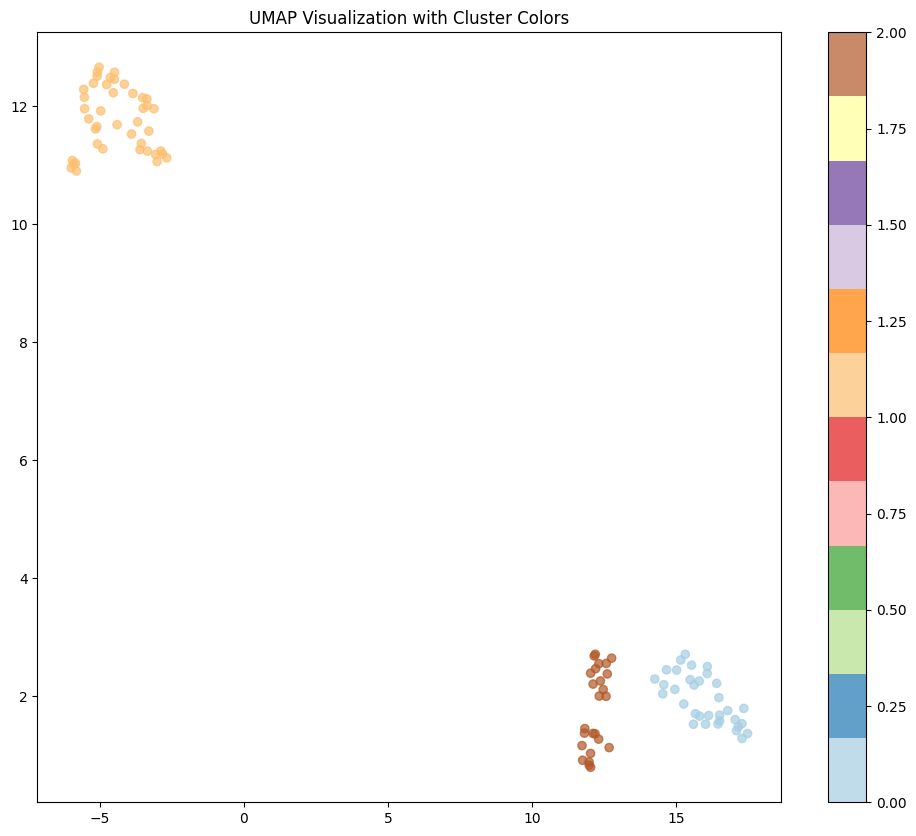

In [43]:
# Visualize with cluster colors
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                     c=umap_labels.labels_, cmap='Paired', alpha=0.7)
plt.colorbar(scatter)
plt.title("UMAP Visualization with Cluster Colors")
plt.show()

#### Cluster model

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, Normalizer
from sklearn.cluster import DBSCAN

##### Clusterization considering graph relation

In [44]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
# L2-normalized inputs
mol_embeddings_norm = Normalizer(norm='l2').fit_transform(mol_embeddings_np)
# Compute cosine affinity matrix (input to SpectralClustering)
affinity_matrix = cosine_similarity(mol_embeddings_norm)  # shape (100, 100) 
#sigma = 0.5
#affinity_matrix = np.exp(-0.5 * (1 - cosine_similarity(mol_embeddings_norm))**2 / sigma**2)
# Configure SpectralClustering to match UMAP/HDBSCAN
clusters_spectral = SpectralClustering(
    n_clusters=3,                # Start with UMAP's visible group count
    affinity='precomputed',       # Use cosine similarity directly
    random_state=42,             # Reproducibility
    n_neighbors=20,              # Match UMAP's n_neighbors
    assign_labels='discretize'   # More stable than 'kmeans' for sparse data
).fit(affinity_matrix)

print(clusters_spectral.labels_)
print(np.unique(clusters_spectral.labels_, return_counts=True))

[0 0 1 1 1 0 1 1 2 0 1 0 1 0 2 2 2 2 0 0 1 1 0 0 0 0 0 1 2 2 1 1 0 1 1 1 1
 0 1 1 0 0 1 2 0 0 0 0 1 0 1 1 1 2 0 0 1 0 2 0 1 0 0 1 0 0 0 0 2 1 1 0 2 2
 2 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 2 1 0 0 0 1 0 0 1]
(array([0, 1, 2]), array([48, 37, 15]))


In [46]:
np.where(clusters_spectral.labels_ == 2)[0]

array([ 8, 14, 15, 16, 17, 28, 29, 43, 53, 58, 68, 72, 73, 74, 91])

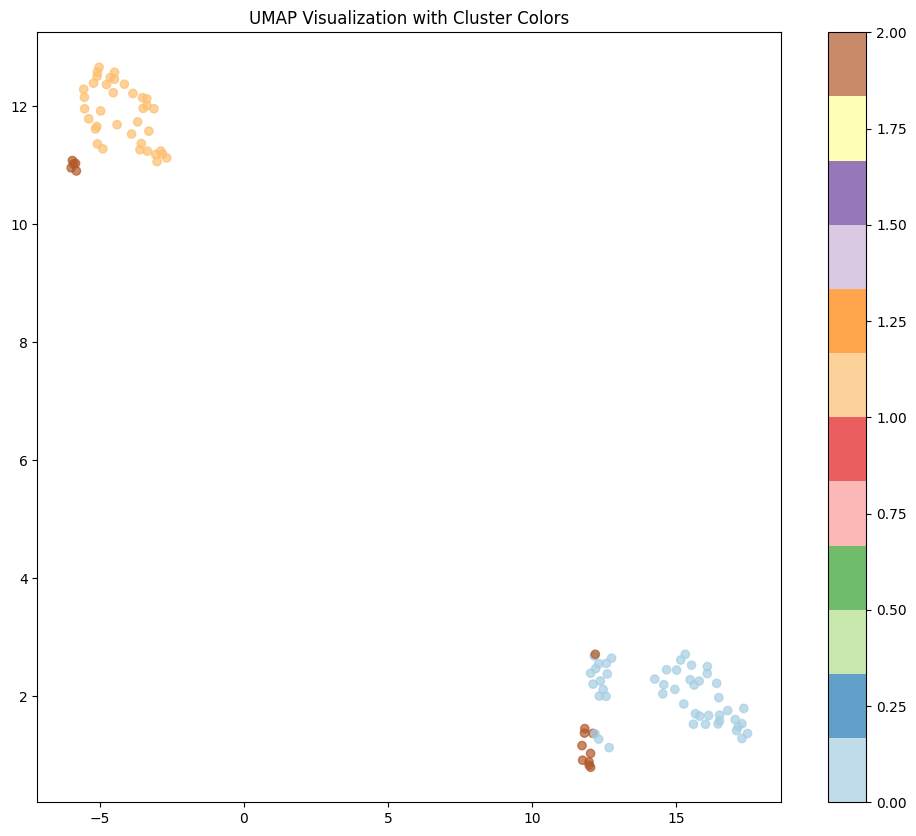

In [47]:
# Visualize with cluster colors
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], 
                     c=clusters_spectral.labels_, cmap='Paired', alpha=0.7)
plt.colorbar(scatter)
plt.title("UMAP Visualization with Cluster Colors")
plt.show()

In [48]:
print(f"Affinity matrix range: {affinity_matrix.min():.2f}, {affinity_matrix.max():.2f}")

Affinity matrix range: 1.00, 1.00
